In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

In [ ]:
from google.colab import drive
import os

drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
base_dir="/content/drive/MyDrive/tea sickness dataset/"
!ls"/content/drive/MyDrive/tea sickness dataset/"

/bin/bash: ls/content/drive/MyDrive/tea sickness dataset/: No such file or directory


In [ ]:
#Menentukan direktori
dataset_dir=os.path.join(base_dir,"bahan/")

In [ ]:
#Menentukan direktori isi bahan
algal_leaf_dir=os.path.join(dataset_dir,"algal leaf/")
Anthracnose_dir=os.path.join(dataset_dir,"Anthracnose/")
bird_eye_spot_dir=os.path.join(dataset_dir,"bird eye spot/")
brown_blight_dir=os.path.join(dataset_dir,"brown blight/")
gray_light_dir=os.path.join(dataset_dir,"gray light/")
healthy_dir=os.path.join(dataset_dir,"healthy/")
red_leaf_spot_dir=os.path.join(dataset_dir,"red leaf spot/")
white_spot_dir=os.path.join(dataset_dir,"white spot/")

print("Jumlah algal leaf:", len(os.listdir(algal_leaf_dir)))
print("Jumlah Anthracnose:" , len(os.listdir(Anthracnose_dir)))
print("Jumlah bird eye spot:" , len(os.listdir(bird_eye_spot_dir)))
print("Jumlah brown blight:" , len(os.listdir(brown_blight_dir)))
print("Jumlah gray light:" , len(os.listdir(gray_light_dir)))
print("Jumlah healthy:" , len(os.listdir(healthy_dir)))
print("Jumlah red leaf spot:" , len(os.listdir(red_leaf_spot_dir)))
print("Jumlah white spot:" , len(os.listdir(white_spot_dir)))

Jumlah algal leaf: 113
Jumlah Anthracnose: 100
Jumlah bird eye spot: 100
Jumlah brown blight: 113
Jumlah gray light: 98
Jumlah healthy: 74
Jumlah red leaf spot: 143
Jumlah white spot: 142


In [ ]:
# Parameter setting
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.1

In [ ]:
# Load data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )

Found 883 files belonging to 8 classes.
Using 795 files for training.


In [ ]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                     validation_split=val_split,
                                                     subset="validation",
                                                     seed=123,
                                                     image_size=(img_height, img_width),
                                                     batch_size=val_batch
                                                    )

Found 883 files belonging to 8 classes.
Using 88 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)

['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


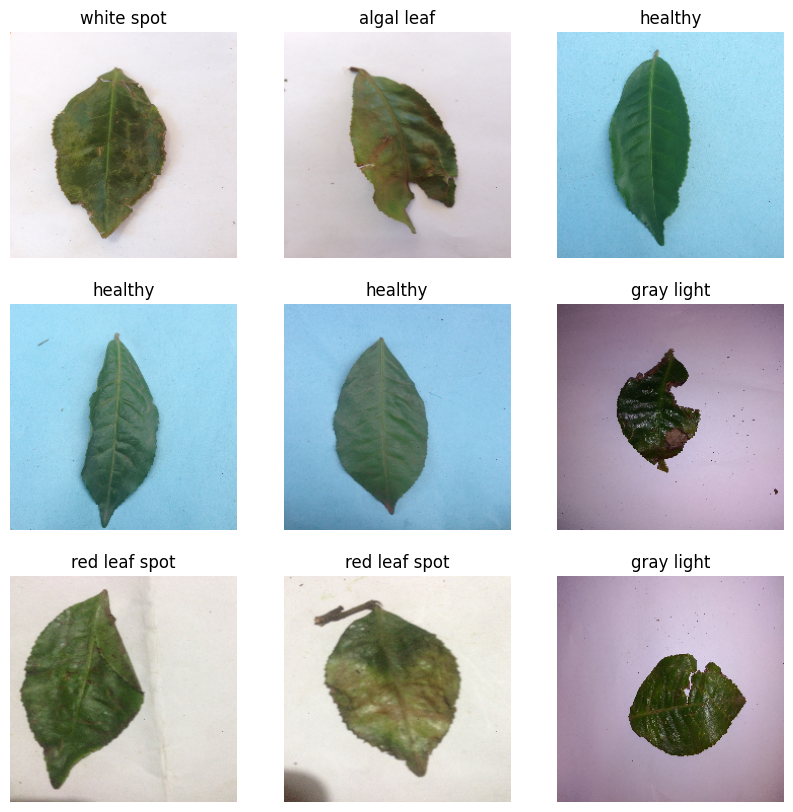

In [ ]:
# Review dataset sample
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Data Preprocessing

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Build Model

In [ ]:
## Data augmentation layers to increase data variation for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [ ]:
# Model architecture
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    layers.BatchNormalization(),
    layers.Dense(num_classes)
])

In [ ]:
# base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze the base model
# base_model.trainable = False

# # Add custom head
# model = tf.keras.models.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     layers.Flatten(),
#     layers.Dropout(0.3),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(8, activation='softmax')
# ])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                  

In [ ]:
# compile model
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                  

In [ ]:
import tensorflow as tf

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.90:
            print("\nAkurasi dan val_akurasi melebihi 0.90, pelatihan dihentikan!")
            self.model.stop_training = True

# Membuat instance callback
callback = MyCallback()

Train Model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=350,
    verbose=1, callbacks=[callback]
)

Epoch 1/350
7/7 [==============================] - 48s 7s/step - loss: 0.4030 - accuracy: 0.8541 - val_loss: 0.4321 - val_accuracy: 0.8295
Epoch 2/350
7/7 [==============================] - 48s 6s/step - loss: 0.4635 - accuracy: 0.8314 - val_loss: 0.4934 - val_accuracy: 0.8068
Epoch 3/350
7/7 [==============================] - 49s 7s/step - loss: 0.4053 - accuracy: 0.8604 - val_loss: 0.3734 - val_accuracy: 0.8636
Epoch 4/350
7/7 [==============================] - 47s 6s/step - loss: 0.4152 - accuracy: 0.8553 - val_loss: 0.5275 - val_accuracy: 0.8295
Epoch 5/350
7/7 [==============================] - 47s 6s/step - loss: 0.3981 - accuracy: 0.8717 - val_loss: 0.5033 - val_accuracy: 0.8182
Epoch 6/350
7/7 [==============================] - 46s 6s/step - loss: 0.3412 - accuracy: 0.8755 - val_loss: 0.4199 - val_accuracy: 0.8409
Epoch 7/350
7/7 [==============================] - 47s 6s/step - loss: 0.3518 - accuracy: 0.8679 - val_loss: 0.4697 - val_accuracy: 0.8295
Epoch 8/350
7/7 [==========

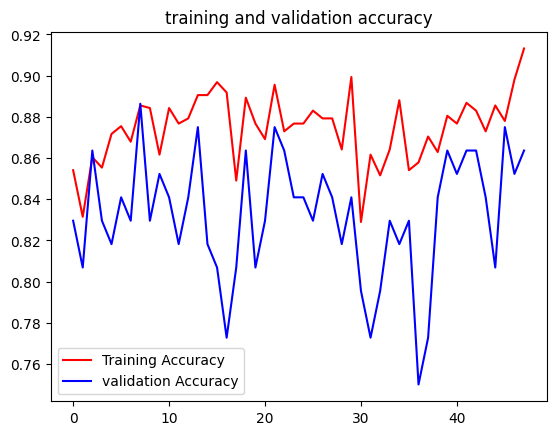

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

epochs=range(len(acc))

plt.plot(epochs,acc,"r",label="Training Accuracy")
plt.plot(epochs,val_acc,"b",label="validation Accuracy")
plt.title("training and validation accuracy")
plt.legend(loc="best")
plt.show()

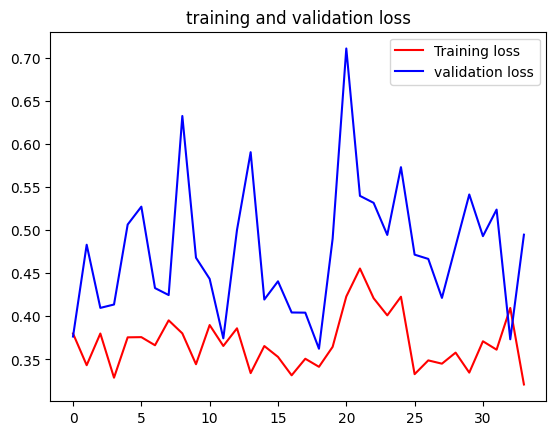

In [ ]:
plt.plot(epochs,loss,"r",label="Training loss")
plt.plot(epochs,val_loss,"b",label="validation loss")
plt.title("training and validation loss")
plt.legend(loc="best")
plt.show()

In [ ]:
saved_model_path = "/content/drive/MyDrive/tea sickness dataset/save fix model/my model fix.h5"
# save model
model.save(saved_model_path)

In [ ]:
# #Define saved model path
# saved_model_path = "/content/drive/MyDrive/tea sickness dataset/save model fix/saved_model"
# tf.saved_model.save(model, saved_model_path)

# #Convert the model
# converted_model = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
# converted_model.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converted_model.convert()

# #Save the model
# os.makedirs('/content/drive/MyDrive/tea sickness dataset/save model fix/model_tflite')
# with open('/content/drive/MyDrive/tea sickness dataset/save model fix/tflite_model.tflite', 'wb') as file:
#   file.write(tflite_model)

Evaluasi Model

In [ ]:
# def load_model():
#   model_path = '/content/drive/MyDrive/tea sickness dataset/save fix model/saved_model.h5'
#   model = tf.saved_model.load(model_path)
#   return model

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/tea sickness dataset/save fix model/model fix.h5')

Predictions:
 [2 7 5 7 3 3 7 7 5 3 5 3 4 4 2 0 0 5 5 6 0 5 0 6 7 0 0 3 1 5 7 1 1 5 0 1 4
 0 2 0 6 3 3 7 0 2 6 1 3 3 3 7 0 0 3 5 0 7 2 6 1 6 7 6 5 1 7 1 7 3 2 0 7 1
 3 3 4 1 1 1 3 1 5 3 4 7 4 6]
Labels:
 [2 7 5 7 3 3 7 1 5 3 5 3 4 4 2 0 0 5 5 6 0 5 0 6 7 2 2 3 1 5 7 1 1 5 4 3 4
 2 2 0 6 3 7 7 0 2 6 1 7 3 3 7 0 0 3 5 0 7 2 6 1 6 7 6 5 1 7 1 7 3 2 0 3 1
 3 3 4 1 1 1 3 1 5 3 4 7 4 6]

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.92      0.92      0.92        13
           2       1.00      0.67      0.80         9
           3       0.88      0.88      0.88        16
           4       1.00      0.86      0.92         7
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         8
           7       0.86      0.86      0.86        14

    accuracy                           0.90        88
   macro avg       0.92      0.90      0.90        88
weighted avg       0

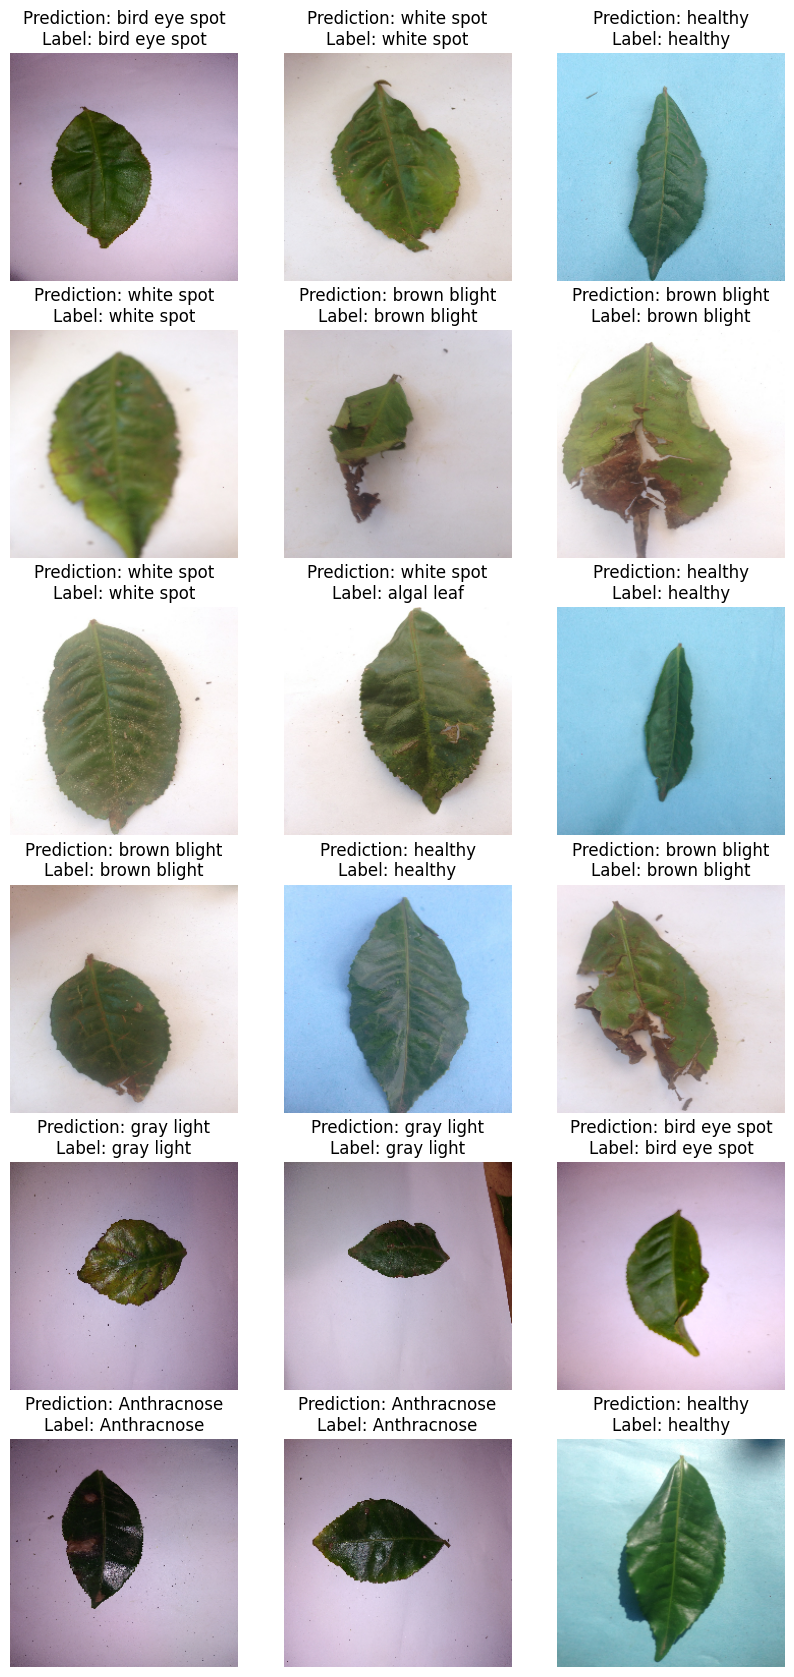

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = '/content/' + fn
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x /= 255
    x=tf.keras.preprocessing.image.img_to_array(img)
    x = tf.expand_dims(x, axis=0)

    predictions = model.predict(x)
    predicted_class = tf.argmax(predictions[0])

    description = ""
    if predicted_class == 0:
      description = "This image belongs to class Algal Leaf"
    elif predicted_class == 1:
      description = "This image belongs to class Anthracnose"
    elif predicted_class == 2:
      description = "This image belongs to class Bird Eye Spot"
    elif predicted_class == 3:
      description = "This image belongs to class Brown Blight"
    elif predicted_class == 4:
      description = "This image belongs to class Gray Light"
    elif predicted_class == 5:
      description = "This image belongs to class Healthy"
    elif predicted_class == 6:
      description = "This image belongs to class Red Leaf Spot"
    elif predicted_class == 7:
      description = "This image belongs to class White Spot"

    print(description)


Saving IMG_20220503_155054.jpg to IMG_20220503_155054.jpg
1/1 [==============================] - 0s 45ms/step
This image belongs to class Bird Eye Spot


In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv("history.csv")
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
43,0.378141,0.872956,0.469091,0.840909
44,0.338973,0.885535,0.542806,0.806818
45,0.340183,0.877987,0.407986,0.875000
46,0.314295,0.898113,0.372482,0.852273
47,0.287927,0.913208,0.420294,0.863636
